# This notebook assumes that we have already downloaded mutual funds historical data and have the following in the data folder:
- correlations data
- Mutual fund historical NAV time series data
- Scheme name mappings and other meta data such as start date, last date, returns, volatility, TER etc. mapped to correct scheme codes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [9]:
data_dir = r'../data/mutual_funds_data'
corr_fname = 'correlation_data_30Sep2024.csv'
all_mf_ts_fname = 'all_mutual_funds_nav_timeseries_data_30Sep2024.csv'
scheme_details_fname = 'mutual_fund_scheme_details.csv'

# Lets load all these into a dataframe
corr_df = pd.read_csv(data_dir+'/'+corr_fname)
all_mf_ts_df = pd.read_csv(data_dir+'/'+all_mf_ts_fname)
scheme_details_df = pd.read_csv(data_dir+'/'+scheme_details_fname)


In [10]:
corr_df.columns

Index(['Unnamed: 0', '118267', '118269', '118273', '118278', '118494',
       '118510', '118525', '118527', '118531',
       ...
       '135677', '135800', '135805', '135810', '135813', '138312', '140228',
       '141226', '141248', '141924'],
      dtype='object', length=153)

In [11]:

corr_df = corr_df.set_index('Unnamed: 0')
corr_df.head()

,118267,118269,118273,118278,118494,118510,118525,118527,118531,118533,...,135677,135800,135805,135810,135813,138312,140228,141226,141248,141924
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
118267,1.000000,0.944580,0.965884,0.965155,0.991193,0.970784,0.993542,0.983451,0.959073,0.989236,...,0.964348,0.896226,0.973969,0.942881,0.964153,0.948156,0.988484,0.979975,0.965621,0.992602
118269,0.944580,1.000000,0.995524,0.994952,0.962688,0.982110,0.949597,0.981264,0.989935,0.974018,...,0.989403,0.982710,0.983896,0.981814,0.989843,0.996482,0.980001,0.988974,0.993329,0.946424
118273,0.965884,0.995524,1.000000,0.996024,0.978871,0.986818,0.968975,0.989774,0.989431,0.985833,...,0.993281,0.967168,0.993675,0.979296,0.989478,0.993622,0.990909,0.995131,0.993605,0.965563
118278,0.965155,0.994952,0.996024,1.000000,0.978978,0.993560,0.969332,0.990995,0.995658,0.987033,...,0.995239,0.975563,0.990681,0.978699,0.995058,0.994737,0.991696,0.995264,0.997020,0.962165
118494,0.991193,0.962688,0.978871,0.978978,1.000000,0.986578,0.996032,0.993702,0.978688,0.991805,...,0.982857,0.923732,0.983526,0.949294,0.977830,0.970079,0.992816,0.988786,0.982283,0.990687


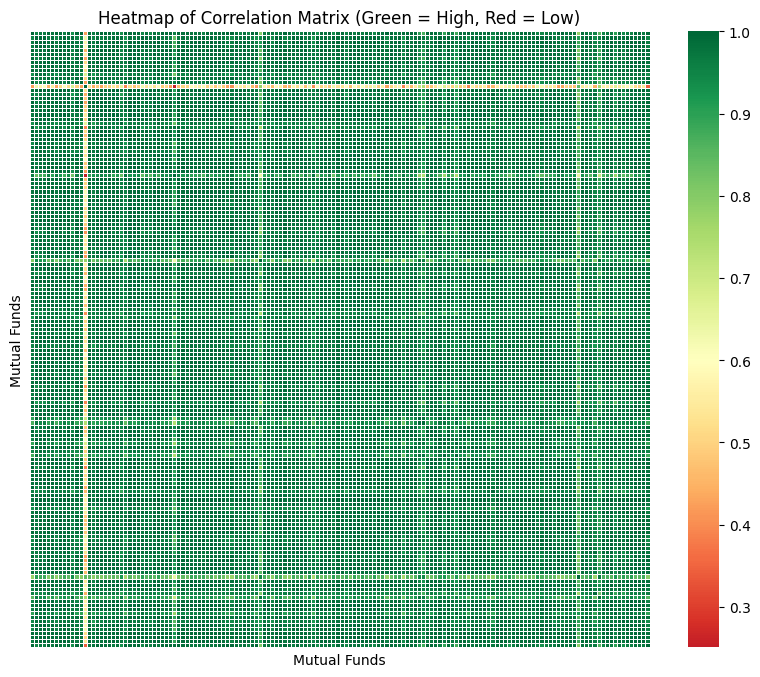

In [13]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_df, annot=False, cmap='RdYlGn', center=0.6, linewidths=0.5, xticklabels=False, yticklabels=False)

# Step 2: Add titles and labels
plt.title("Heatmap of Correlation Matrix (Green = High, Red = Low)")
plt.xlabel('Mutual Funds')
plt.ylabel('Mutual Funds')
plt.savefig(r'../results/figures/all_152_mf_correlations_heatmap')
plt.show()

In [14]:
all_mf_ts_df.head()

,Date,118267,118269,118273,118278,118494,118510,118525,118527,118531,...,135677,135800,135805,135810,135813,138312,140228,141226,141248,141924
0,2013-01-01,0.00,0.00,0.00,0.00,125.9270,35.6864,17.2013,23.3746,238.3444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-02,23.03,12.11,16.58,27.85,126.7526,35.8588,17.3822,23.5449,239.4858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-03,23.12,12.12,16.55,27.87,127.6991,36.1530,17.4254,23.7741,240.4566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-04,23.29,12.14,16.55,28.00,128.5925,36.3129,17.4203,23.9391,240.8963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-07,23.30,12.10,16.49,28.06,129.3380,36.2857,17.4176,24.0274,240.7371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
scheme_details_df.head()

,Scheme Code,Scheme Name,Start Date,Last Date,ret_0.5Y,ret_1Y,ret_2Y,ret_3Y,ret_5Y,vol_0.5Y,...,Scheme Cat1,Scheme Cat2,Scheme Code Direct,Scheme Code Reg,Master Scheme Name Reg,Master Scheme Name Direct,TER scheme name,Direct TER,Regular TER,type
0,119711.0,SBI MAGNUM GLOBAL FUND - DIRECT PLAN -GROWTH,1/2/2013,9/30/2024,23.569970,14.472202,15.831791,10.331796,15.794515,10.027417,...,Equity,ELSS,119711.0,103034.0,SBI MAGNUM GLOBAL FUND - REGULAR PLAN -GROWTH,SBI MAGNUM GLOBAL FUND - DIRECT PLAN -GROWTH,SBI MAGNUM GLOBAL FUND,1.18,1.87,Direct
1,120490.0,JM Large Cap Fund (Direct) - Growth Option,1/2/2013,9/30/2024,29.105410,38.086719,27.681011,17.318324,19.120608,18.240506,...,Equity,Large & Mid Cap Fund,120490.0,100219.0,JM Large Cap Fund (Regular) - Growth Option,JM Large Cap Fund (Direct) - Growth Option,JM Large Cap Fund,1.01,2.41,Direct
2,119646.0,Aditya Birla Sun Life MNC Fund - Growth - Dire...,1/2/2013,9/30/2024,43.735352,32.470009,22.281705,13.084314,12.886560,11.894098,...,Equity,ELSS,119646.0,100064.0,Aditya Birla Sun Life MNC Fund - Growth - Regu...,Aditya Birla Sun Life MNC Fund - Growth - Dire...,Aditya Birla Sun Life MNC Fund,1.29,1.98,Direct
3,120587.0,ICICI Prudential FMCG Fund - Direct Plan - Gr...,1/2/2013,9/30/2024,41.555779,22.313523,20.012691,16.271832,15.810790,12.303108,...,Equity,ELSS,120587.0,100352.0,ICICI Prudential FMCG Fund - Growth,ICICI Prudential FMCG Fund - Direct Plan - Gr...,ICICI Prudential FMCG Fund,1.29,2.16,Direct
4,120682.0,UTI - MNC Fund - Growth Option - Direct,1/2/2013,9/30/2024,39.116739,32.650288,22.656071,14.418454,15.652043,11.203511,...,Equity,ELSS,120682.0,100740.0,UTI - MNC Fund - Regular Plan - Growth Option,UTI - MNC Fund - Growth Option - Direct,UTI - MNC Fund,1.19,2.00,Direct


In [16]:
distance_matrix = 1 - corr_df
distance_matrix

,118267,118269,118273,118278,118494,118510,118525,118527,118531,118533,...,135677,135800,135805,135810,135813,138312,140228,141226,141248,141924
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
118267,0.000000,0.055420,0.034116,0.034845,0.008807,0.029216,0.006458,0.016549,0.040927,0.010764,...,0.035652,0.103774,0.026031,0.057119,0.035847,0.051844,0.011516,0.020025,0.034379,0.007398
118269,0.055420,0.000000,0.004476,0.005048,0.037312,0.017890,0.050403,0.018736,0.010065,0.025982,...,0.010597,0.017290,0.016104,0.018186,0.010157,0.003518,0.019999,0.011026,0.006671,0.053576
118273,0.034116,0.004476,0.000000,0.003976,0.021129,0.013182,0.031025,0.010226,0.010569,0.014167,...,0.006719,0.032832,0.006325,0.020704,0.010522,0.006378,0.009091,0.004869,0.006395,0.034437
118278,0.034845,0.005048,0.003976,0.000000,0.021022,0.006440,0.030668,0.009005,0.004342,0.012967,...,0.004761,0.024437,0.009319,0.021301,0.004942,0.005263,0.008304,0.004736,0.002980,0.037835
118494,0.008807,0.037312,0.021129,0.021022,0.000000,0.013422,0.003968,0.006298,0.021312,0.008195,...,0.017143,0.076268,0.016474,0.050706,0.022170,0.029921,0.007184,0.011214,0.017717,0.009313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138312,0.051844,0.003518,0.006378,0.005263,0.029921,0.011101,0.042566,0.017157,0.005207,0.021587,...,0.007447,0.023275,0.015461,0.027385,0.011274,0.000000,0.018816,0.011204,0.003395,0.045286
140228,0.011516,0.019999,0.009091,0.008304,0.007184,0.009337,0.009856,0.003725,0.013684,0.002463,...,0.011819,0.051995,0.006596,0.025057,0.010727,0.018816,0.000000,0.003328,0.010903,0.015675
141226,0.020025,0.011026,0.004869,0.004736,0.011214,0.008967,0.016300,0.003746,0.010144,0.007564,...,0.006839,0.038495,0.006145,0.021607,0.005991,0.011204,0.003328,0.000000,0.005294,0.023450


C:\Users\abc\AppData\Local\Temp\ipykernel_15040\2826280902.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')  # 'ward' minimizes variance within clusters


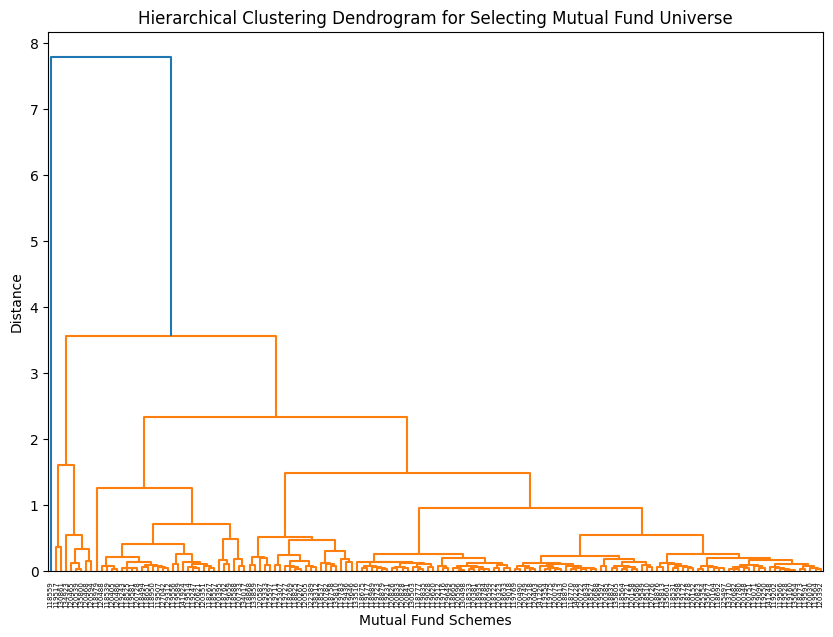

    MutualFunds  Cluster
56       119517        1
134      130861        2
143      135800        3
95       120465        3
101      120539        3
..          ...      ...
126      125354       24
127      125497       24
118      120823       24
90       120392       24
13       118559       25

[152 rows x 2 columns]


In [18]:
# Step 2: Perform hierarchical clustering using the 'linkage' function
Z = linkage(distance_matrix, method='ward')  # 'ward' minimizes variance within clusters

# Step 3: Plot a dendrogram to visualize the clusters
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=corr_df.columns)
plt.title("Hierarchical Clustering Dendrogram for Selecting Mutual Fund Universe")
plt.xlabel("Mutual Fund Schemes")
plt.ylabel("Distance")
plt.savefig(r'../results/figures/hierarchical_clustering_results')
plt.show()

# Step 4: Cut the dendrogram to form clusters
# fcluster allows you to cut the dendrogram at a certain threshold
clusters = fcluster(Z, t=0.2, criterion='distance')  # You can adjust the threshold 't'

# Step 5: Assign each stock to a cluster and view the clusters
clustered_stocks = pd.DataFrame({'MutualFunds': corr_df.columns, 'Cluster': clusters})

# Display the clustered stocks
print(clustered_stocks.sort_values('Cluster'))

In [21]:
clustered_stocks.to_clipboard()
correlation_matrix = corr_df.copy()

In [22]:
def select_first_stock_from_each_cluster(clustered_stocks):
    representative_stocks = []

    # Loop through each unique cluster and select the first stock from each cluster
    for cluster_id in clustered_stocks['Cluster'].unique():
        # Get the first stock in this cluster
        first_stock = clustered_stocks[clustered_stocks['Cluster'] == cluster_id].iloc[0]['MutualFunds']
        representative_stocks.append(int(first_stock))

    return representative_stocks

# Step 2: Apply the function to get the first stock from each cluster
selected_stocks = select_first_stock_from_each_cluster(clustered_stocks)

# Display the selected stocks
print("First Stocks from each cluster:")
print(selected_stocks)

First Stocks from each cluster:
[118267, 118269, 118273, 118278, 118494, 118510, 118527, 118533, 118537, 118539, 118559, 118588, 118675, 118762, 118868, 118979, 119333, 119436, 119517, 119556, 119711, 120465, 120468, 130861, 134923]


In [23]:
correlation_matrix.columns = [int(x) for x in correlation_matrix.columns]
correlation_matrix.columns

Index([118267, 118269, 118273, 118278, 118494, 118510, 118525, 118527, 118531,
       118533,
       ...
       135677, 135800, 135805, 135810, 135813, 138312, 140228, 141226, 141248,
       141924],
      dtype='int64', length=152)

In [24]:
filtered_correlation_matrix = correlation_matrix.loc[selected_stocks, selected_stocks]

# Step 2: Display the filtered correlation matrix
print("Filtered Correlation Matrix:")
print(filtered_correlation_matrix)

Filtered Correlation Matrix:
              118267    118269    118273    118278    118494    118510  \
Unnamed: 0                                                               
118267      1.000000  0.944580  0.965884  0.965155  0.991193  0.970784   
118269      0.944580  1.000000  0.995524  0.994952  0.962688  0.982110   
118273      0.965884  0.995524  1.000000  0.996024  0.978871  0.986818   
118278      0.965155  0.994952  0.996024  1.000000  0.978978  0.993560   
118494      0.991193  0.962688  0.978871  0.978978  1.000000  0.986578   
118510      0.970784  0.982110  0.986818  0.993560  0.986578  1.000000   
118527      0.983451  0.981264  0.989774  0.990995  0.993702  0.991442   
118533      0.989236  0.974018  0.985833  0.987033  0.991805  0.990192   
118537      0.928446  0.987025  0.977941  0.981486  0.942401  0.969062   
118539      0.991196  0.955046  0.970927  0.969372  0.984032  0.972854   
118559      0.423527  0.632447  0.574529  0.594227  0.454005  0.554526   
118588   

In [25]:
filtered_correlation_matrix.columns

Index([118267, 118269, 118273, 118278, 118494, 118510, 118527, 118533, 118537,
       118539, 118559, 118588, 118675, 118762, 118868, 118979, 119333, 119436,
       119517, 119556, 119711, 120465, 120468, 130861, 134923],
      dtype='int64')

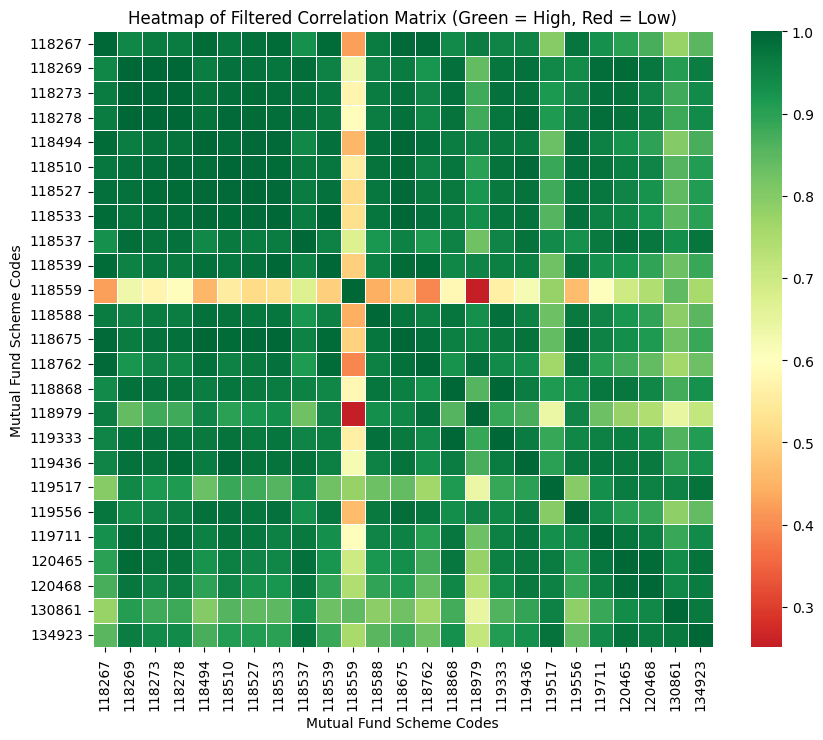

In [26]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(filtered_correlation_matrix, annot=False, cmap='RdYlGn', center=0.6, linewidths=0.5)

# Step 2: Add titles and labels
plt.title("Heatmap of Filtered Correlation Matrix (Green = High, Red = Low)")
plt.ylabel("Mutual Fund Scheme Codes")
plt.xlabel("Mutual Fund Scheme Codes")
plt.savefig(r'../results/figures/25_mfs_correlation_heatmap')
plt.show()

In [27]:
scheme_details_df[scheme_details_df['Scheme Code'].isin(selected_stocks)]

,Scheme Code,Scheme Name,Start Date,Last Date,ret_0.5Y,ret_1Y,ret_2Y,ret_3Y,ret_5Y,vol_0.5Y,...,Scheme Cat1,Scheme Cat2,Scheme Code Direct,Scheme Code Reg,Master Scheme Name Reg,Master Scheme Name Direct,TER scheme name,Direct TER,Regular TER,type
0,119711.0,SBI MAGNUM GLOBAL FUND - DIRECT PLAN -GROWTH,1/2/2013,9/30/2024,23.569970,14.472202,15.831791,10.331796,15.794515,10.027417,...,Equity,ELSS,119711.0,103034.0,SBI MAGNUM GLOBAL FUND - REGULAR PLAN -GROWTH,SBI MAGNUM GLOBAL FUND - DIRECT PLAN -GROWTH,SBI MAGNUM GLOBAL FUND,1.18,1.87,Direct
9,118527.0,Templeton India Equity Income Fund - Direct - ...,1/1/2013,9/30/2024,34.733927,43.464935,31.260749,20.823448,24.494530,17.001978,...,Equity,Value Fund,118527.0,103678.0,Templeton India Equity Income Fund-Growth Plan,Templeton India Equity Income Fund - Direct - ...,Templeton India Equity Income Fund,1.22,2.06,Direct
24,120465.0,Axis Bluechip Fund - Direct Plan - Growth,1/2/2013,9/30/2024,27.367383,29.934646,20.061486,9.339852,14.931922,13.900641,...,Equity,Large & Mid Cap Fund,120465.0,112277.0,Axis Bluechip Fund - Regular Plan - Growth,Axis Bluechip Fund - Direct Plan - Growth,Axis Bluechip Fund,0.67,1.56,Direct
39,118269.0,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,1/2/2013,9/30/2024,33.566807,33.840713,24.050435,14.219408,19.035227,14.880022,...,Equity,Large & Mid Cap Fund,118269.0,113221.0,CANARA ROBECO BLUE CHIP EQUITY FUND - REGULAR ...,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,Canara Robeco Bluechip Equity Fund,0.45,1.65,Direct
45,118273.0,CANARA ROBECO CONSUMER TRENDS FUND - DIRECT PL...,1/2/2013,9/30/2024,43.374904,39.392488,26.326191,18.547042,21.466636,13.444265,...,Equity,ELSS,118273.0,112152.0,CANARA ROBECO CONSUMER TRENDS FUND - REGULAR P...,CANARA ROBECO CONSUMER TRENDS FUND - DIRECT PL...,Canara Robeco Consumer Trends Fund,0.81,2.08,Direct
46,119517.0,Aditya Birla Sun Life International Equity Fun...,1/2/2013,9/30/2024,17.921626,23.303798,16.090366,6.469693,10.132782,9.934792,...,Equity,ELSS,119517.0,106873.0,Aditya Birla Sun Life International Equity Fun...,Aditya Birla Sun Life International Equity Fun...,Aditya Birla Sun Life International Equity Fund,1.93,2.52,Direct
52,118533.0,Franklin India Prima Fund - Direct - Growth,1/1/2013,9/30/2024,48.204558,44.402839,32.062777,19.335539,22.501199,16.522469,...,Equity,Small Cap Fund,118533.0,100473.0,Franklin India Prima Fund-Growth,Franklin India Prima Fund - Direct - Growth,Franklin India Prima Fund,0.96,1.76,Direct
53,130861.0,Nippon India Japan Equity Fund- Direct Plan- G...,8/27/2014,9/30/2024,12.430239,18.883731,16.626109,5.994041,10.031238,23.024628,...,Equity,ELSS,130861.0,130858.0,Nippon India Japan Equity Fund- Growth Plan- B...,Nippon India Japan Equity Fund- Direct Plan- G...,Nippon India Japan Equity Fund,1.20,2.45,Direct
57,118278.0,CANARA ROBECO EMERGING EQUITIES - DIRECT PLAN ...,1/2/2013,9/30/2024,40.897469,38.541460,25.333221,15.327130,21.584026,15.854581,...,Equity,Mid Cap Fund,118278.0,102920.0,CANARA ROBECO EMERGING EQUITIES - REGULAR PLAN...,CANARA ROBECO EMERGING EQUITIES - DIRECT PLAN ...,Canara Robeco Emerging Equities,0.54,1.59,Direct
64,120468.0,Axis Focused 25 Fund - Direct Plan - Growth Op...,1/2/2013,9/30/2024,29.120248,30.175204,18.180057,7.164893,13.726238,14.056462,...,Equity,Sectoral/ Thematic,120468.0,117560.0,Axis Focused 25 Fund - Regular Plan - Growth O...,Axis Focused 25 Fund - Direct Plan - Growth Op...,Axis Focused Fund,0.81,1.72,Direct


In [33]:
scheme_details_df[scheme_details_df['Scheme Code'].isin(selected_stocks)].to_clipboard()


In [34]:
all_mf_ts_df.columns


Index(['Date', '118267', '118269', '118273', '118278', '118494', '118510',
       '118525', '118527', '118531',
       ...
       '135677', '135800', '135805', '135810', '135813', '138312', '140228',
       '141226', '141248', '141924'],
      dtype='object', length=153)

In [28]:
str_list_sel_mfs = [str(x) for x in selected_stocks]
all_mf_ts_df = all_mf_ts_df[['Date']+str_list_sel_mfs]

In [29]:
all_mf_ts_df = all_mf_ts_df[all_mf_ts_df['Date'] > '2017-01-01']

In [30]:
all_mf_ts_df.columns

Index(['Date', '118267', '118269', '118273', '118278', '118494', '118510',
       '118527', '118533', '118537', '118539', '118559', '118588', '118675',
       '118762', '118868', '118979', '119333', '119436', '119517', '119556',
       '119711', '120465', '120468', '130861', '134923'],
      dtype='object')

In [31]:
all_mf_ts_df.to_csv(data_dir+'/'+'selected_mutualfunds_nav_timeseries_data.csv')

In [33]:
all_mf_ts_df = all_mf_ts_df.set_index('Date')
all_mf_ts_df

,118267,118269,118273,118278,118494,118510,118527,118533,118537,118539,...,118979,119333,119436,119517,119556,119711,120465,120468,130861,134923
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,39.83,17.97,26.99,67.65,208.7252,64.5967,36.8380,766.9759,113.0898,58.7890,...,16.314,16.1800,328.07,16.3717,29.7957,136.5179,19.21,19.37,0.0000,0.0000
2017-01-03,40.52,18.05,27.23,68.42,209.2624,64.8619,36.9201,771.7870,113.4253,58.9800,...,16.460,16.2900,330.43,16.4113,30.0830,137.2512,19.28,19.36,0.0000,10.8127
2017-01-04,40.35,18.05,27.22,68.55,208.6020,64.9970,36.9156,772.2721,114.7742,59.1187,...,16.463,16.2600,330.09,16.5328,30.1584,137.5075,19.23,19.23,10.8200,10.9242
2017-01-05,40.71,18.27,27.51,69.19,210.9426,65.6273,37.4200,779.4939,114.3958,59.5982,...,16.690,16.5100,334.56,16.6466,30.4592,138.2355,19.41,19.37,10.9093,10.8579
2017-01-06,40.34,18.20,27.46,69.07,210.4810,65.4541,37.4153,778.7771,112.8204,59.4785,...,16.626,16.6200,334.24,16.6856,30.3729,137.9466,19.36,19.37,10.9202,10.9250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,187.81,74.21,135.75,302.66,844.6145,216.4727,161.6972,3190.6259,602.9832,283.9190,...,54.984,51.0508,1056.89,38.2594,104.4126,420.2014,72.71,66.45,21.1255,35.4348
2024-09-25,188.26,74.21,135.17,301.56,846.0108,215.6715,162.3693,3173.1208,599.2975,282.9999,...,54.947,50.9782,1053.41,38.1553,104.2232,417.5602,72.65,66.04,21.2646,35.2729
2024-09-26,188.06,74.70,135.81,303.04,849.5571,216.6158,163.3948,3166.0661,600.0169,282.6980,...,55.018,51.3346,1055.98,38.5717,104.2003,418.8087,73.14,66.41,21.6003,35.6675


0.3170119850276683


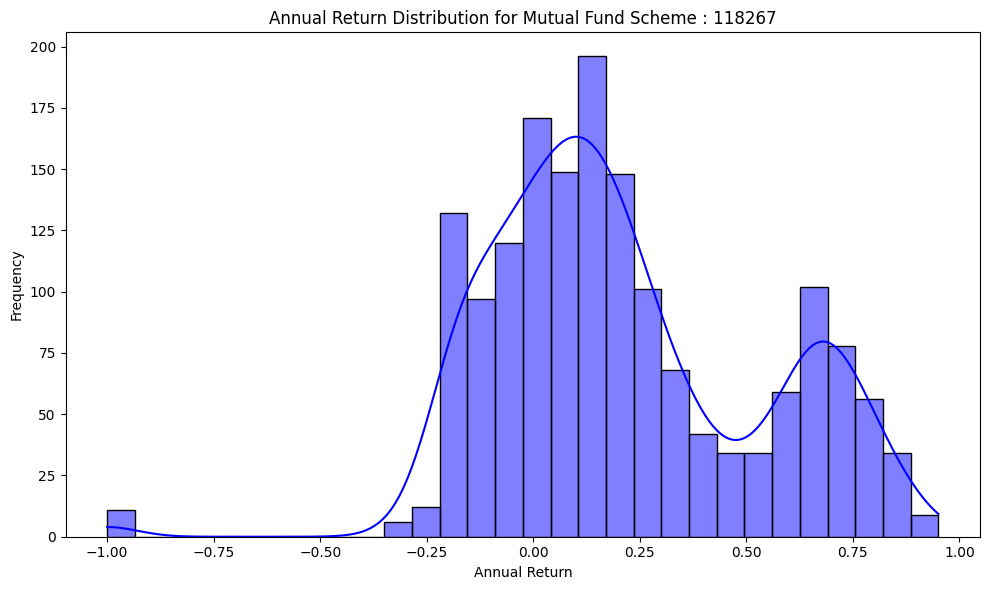

0.19002668310564766


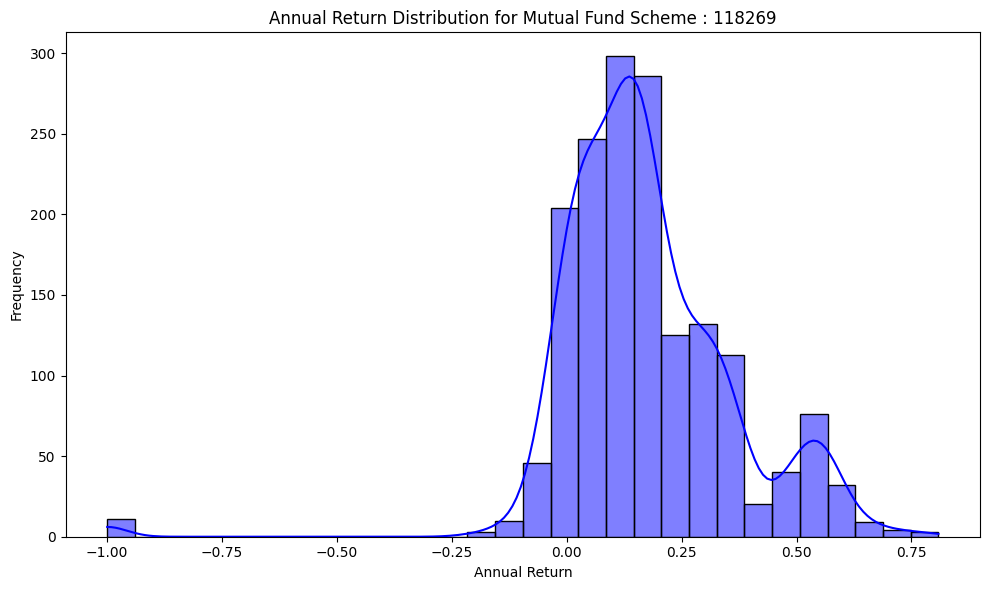

0.20282422254818594


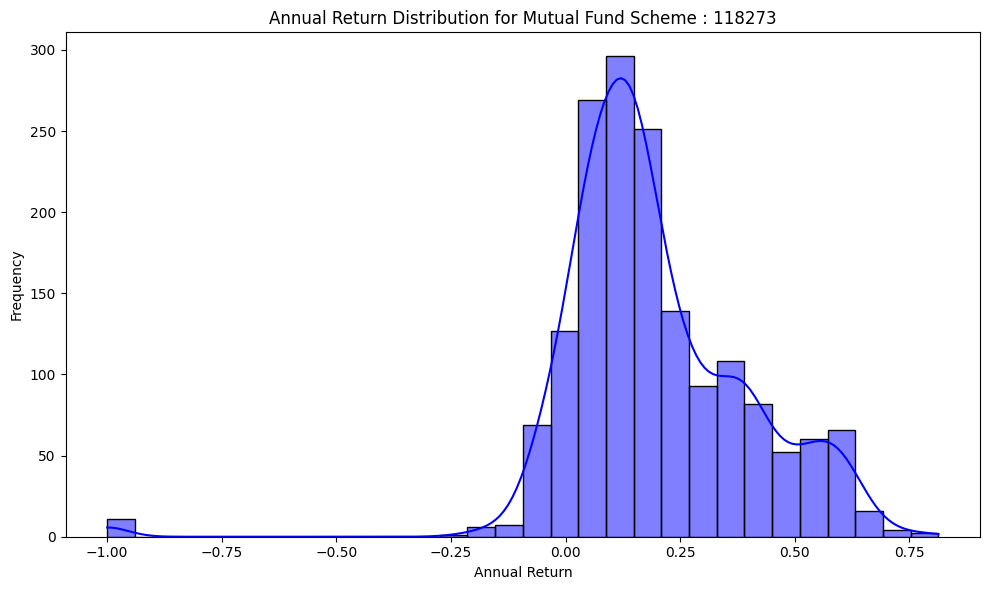

0.2385417628053405


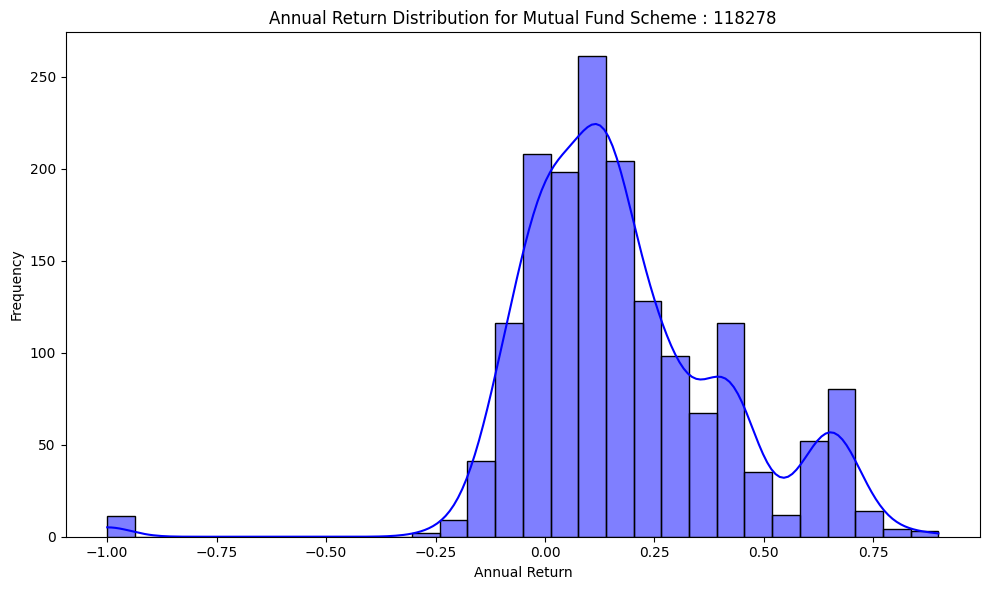

0.3157295995865191


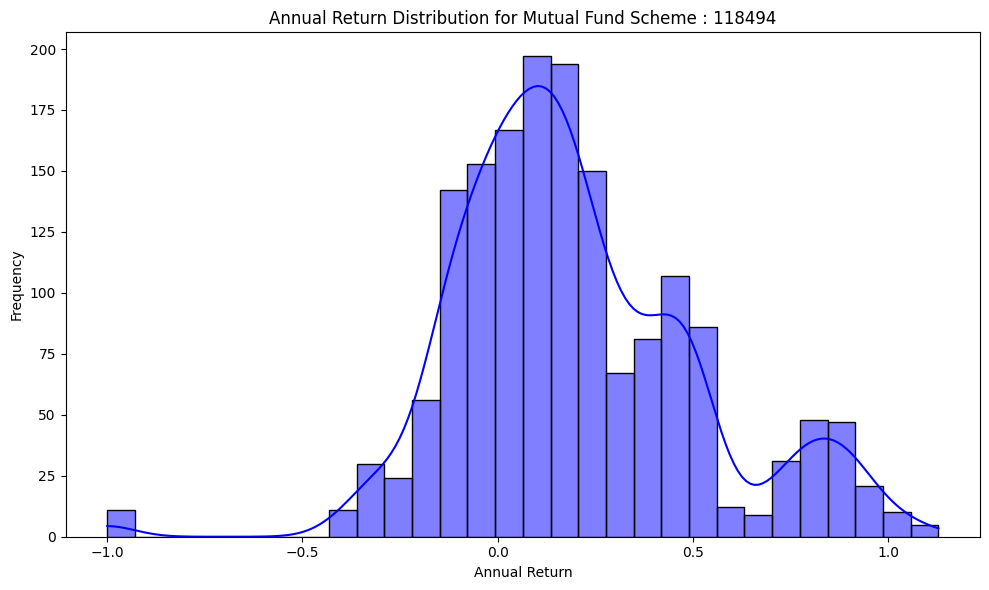

0.2744399195846976


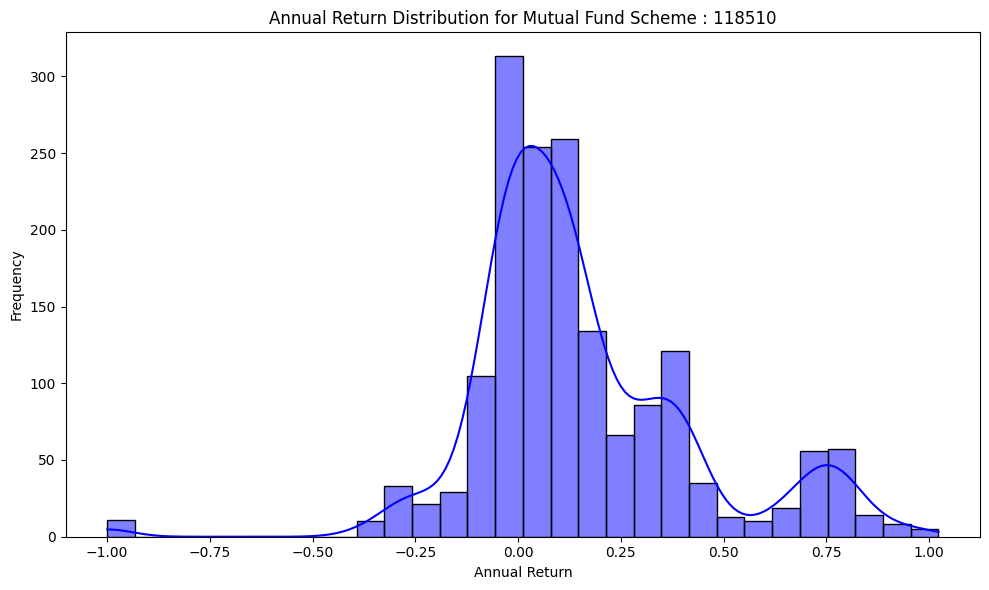

0.2835981182564493


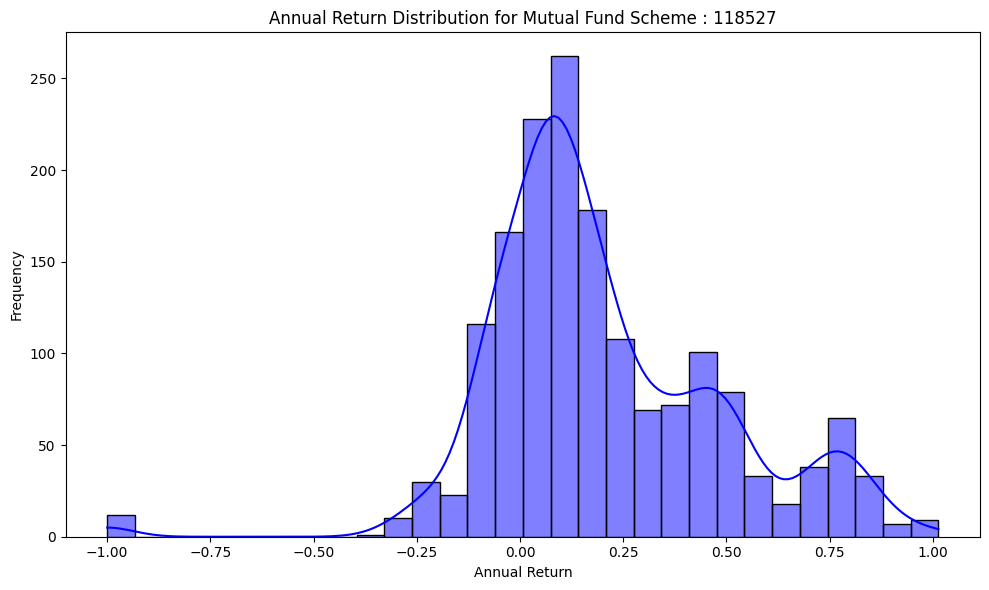

0.2742719417691348


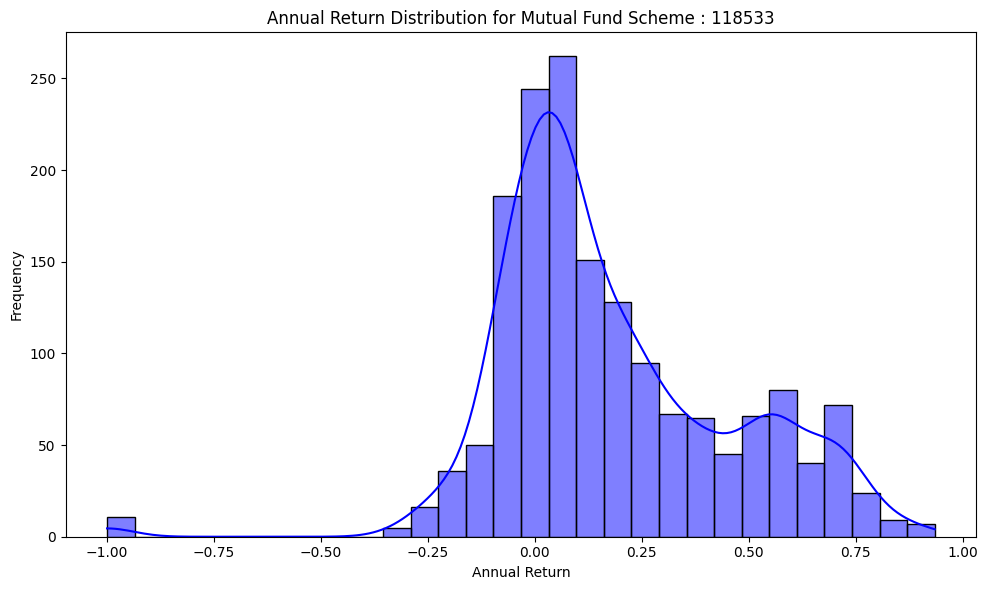

0.29415916096473743


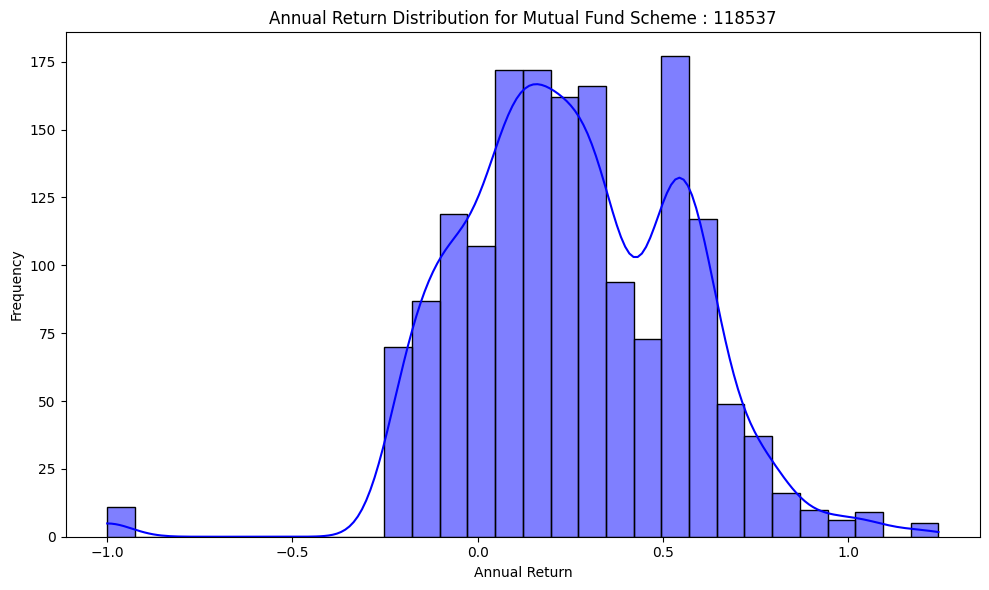

0.31511456459269416


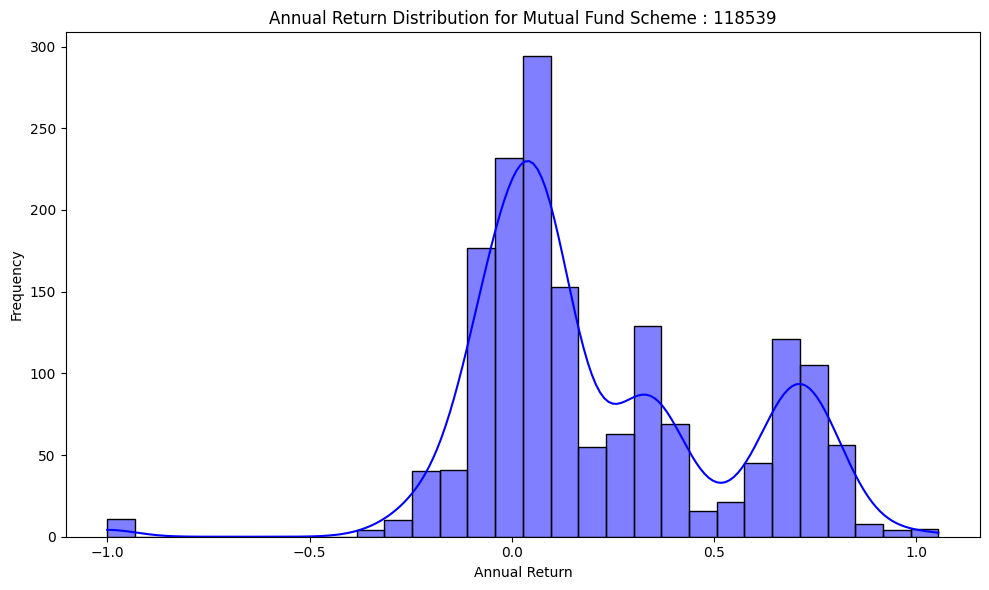

0.19496532058097873


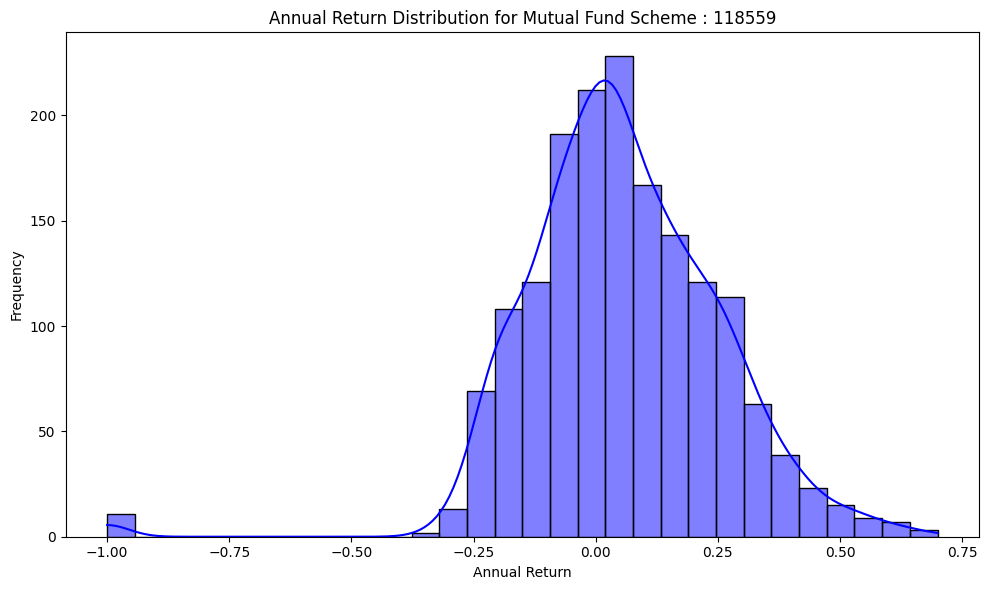

0.29697444900179665


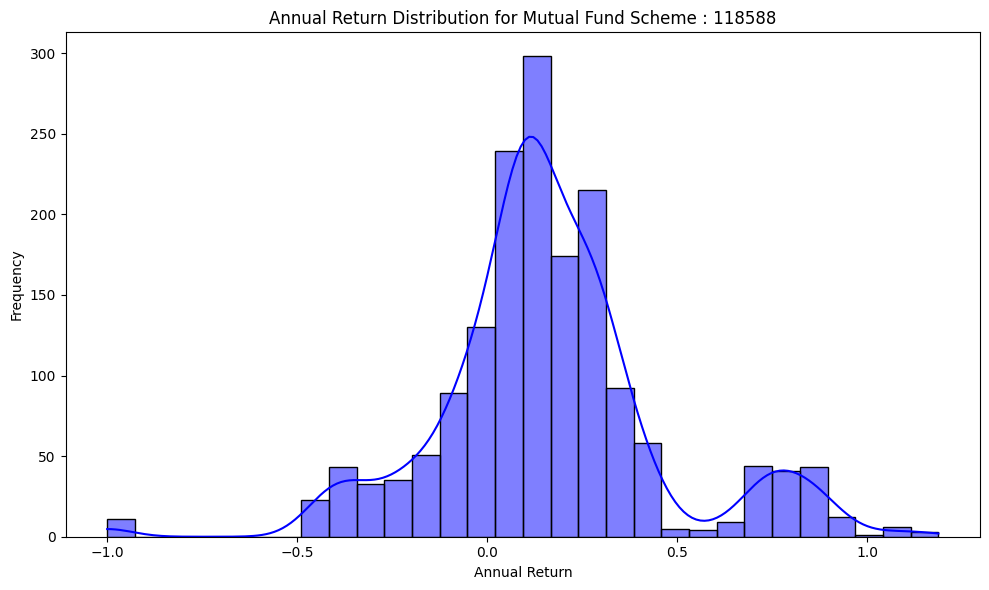

0.26687389749079177


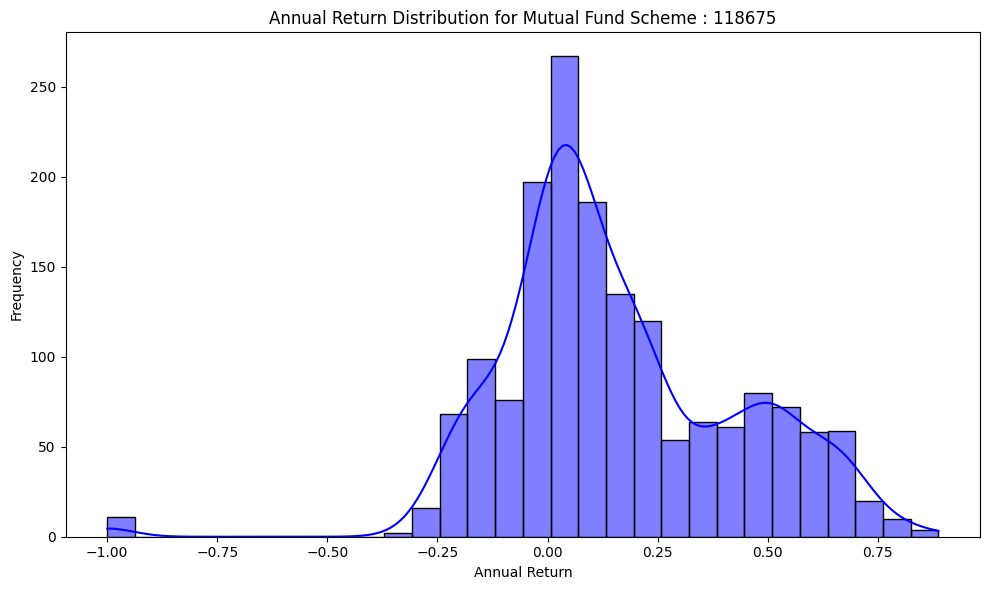

0.34940182451173296


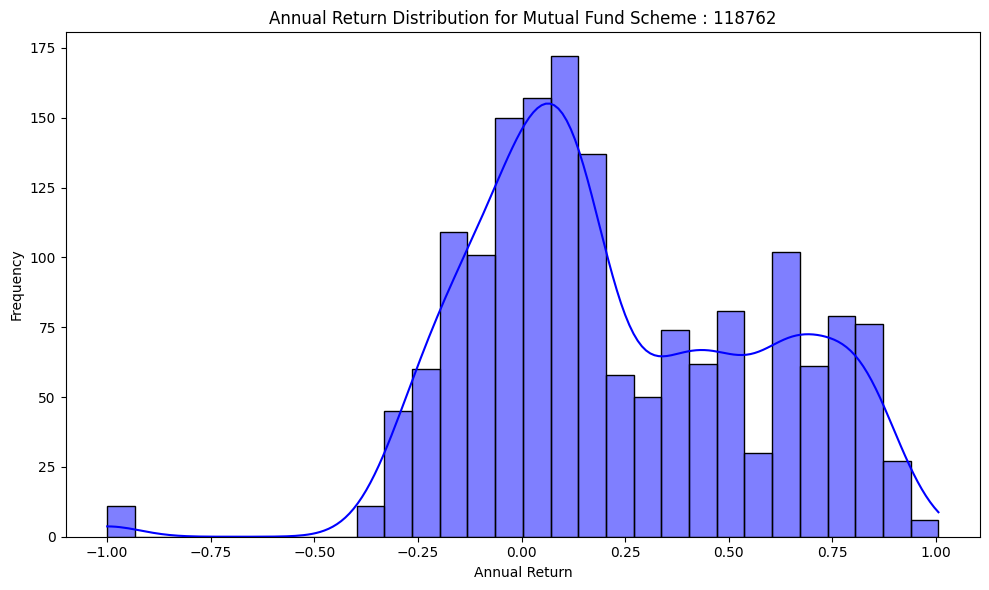

0.2090799372787088


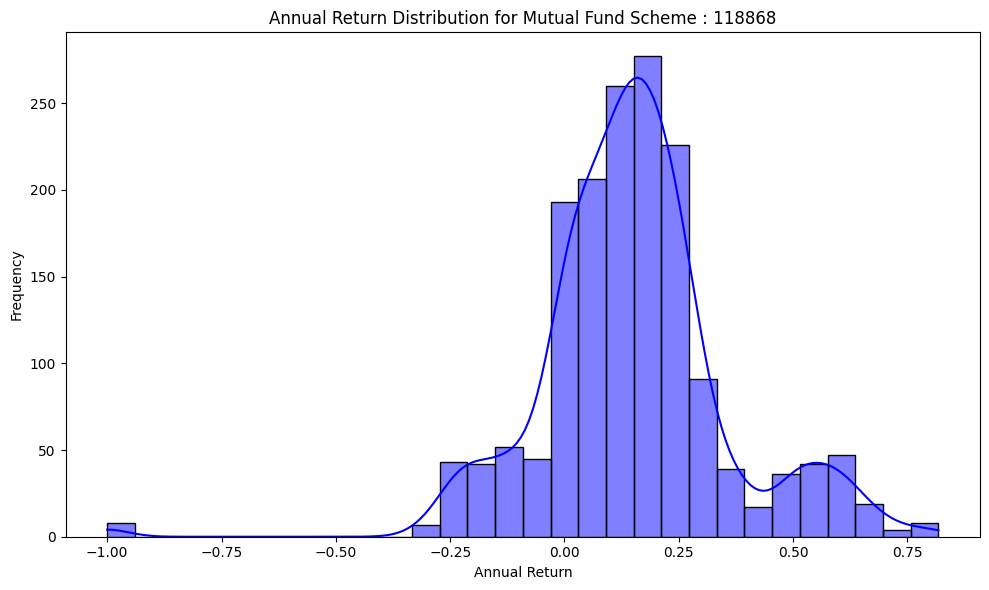

0.391289166937901


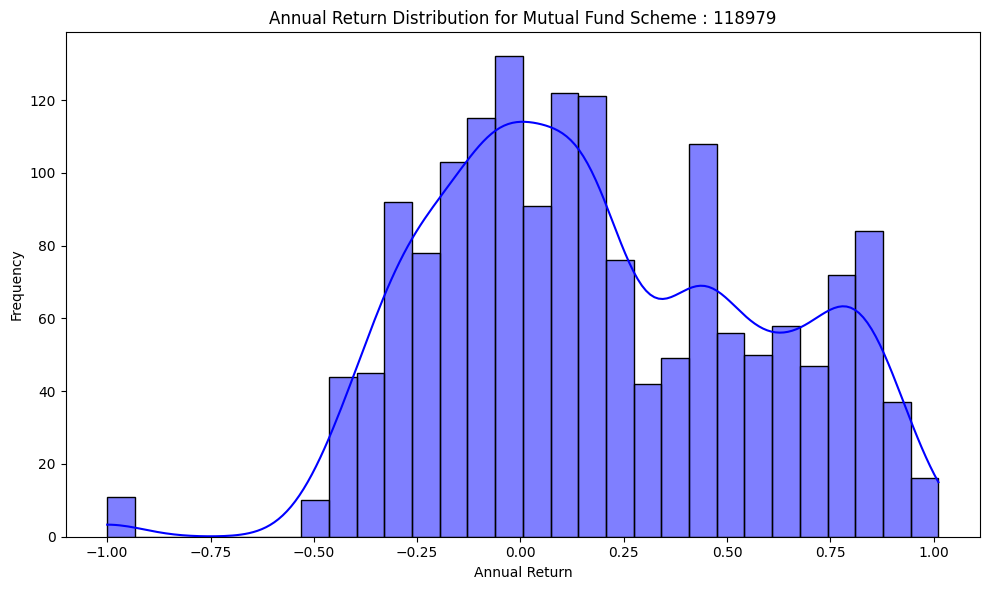

0.21711302119918183


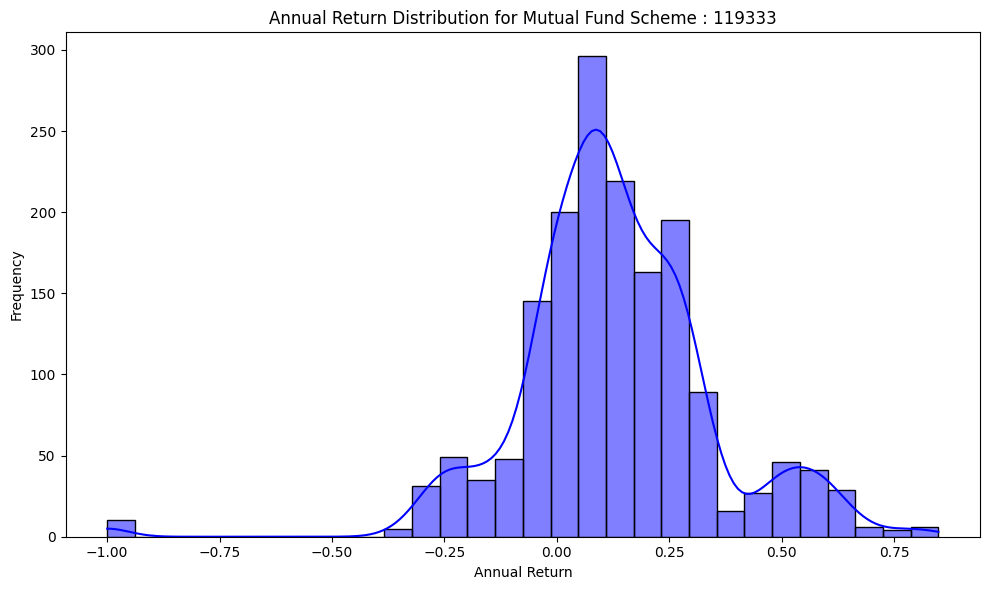

0.2657365520913112


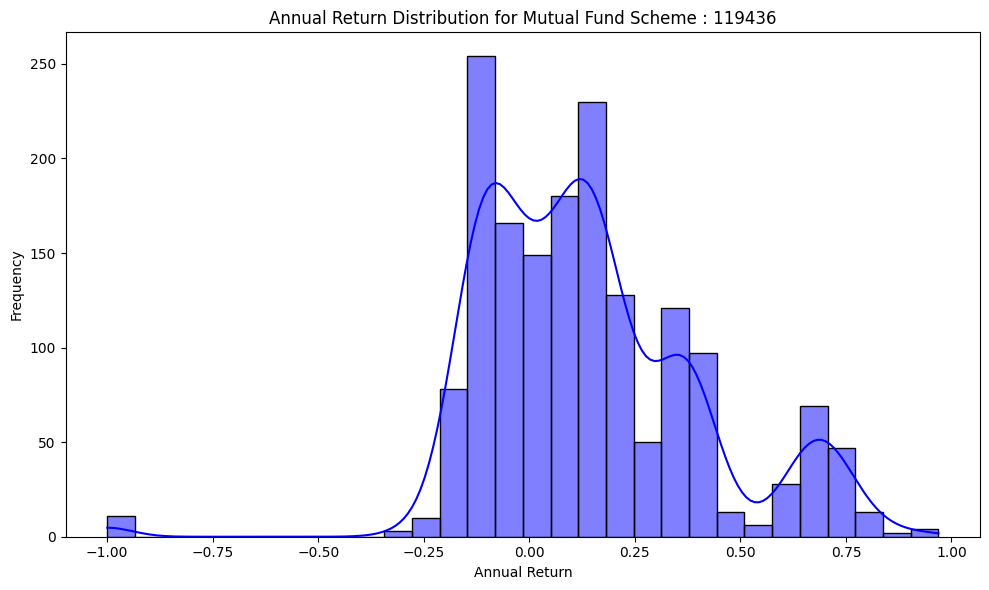

0.13642961476703627


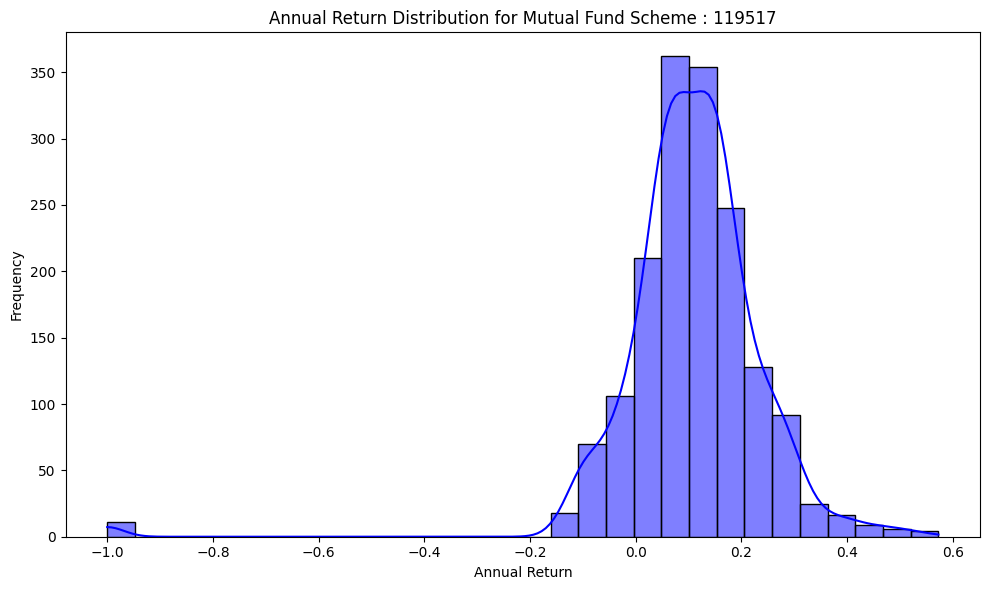

0.3765311432213018


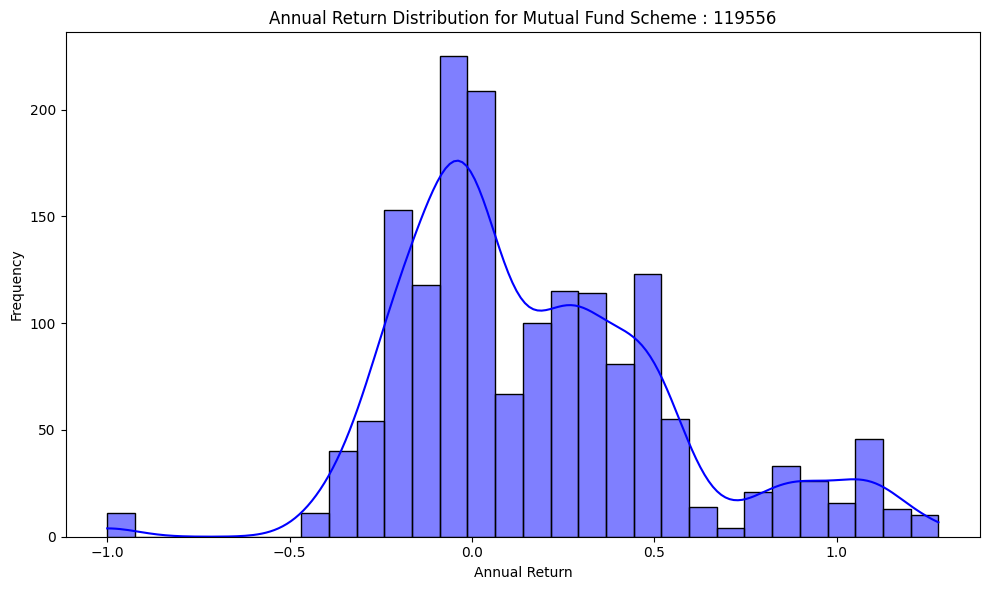

0.18936099450189364


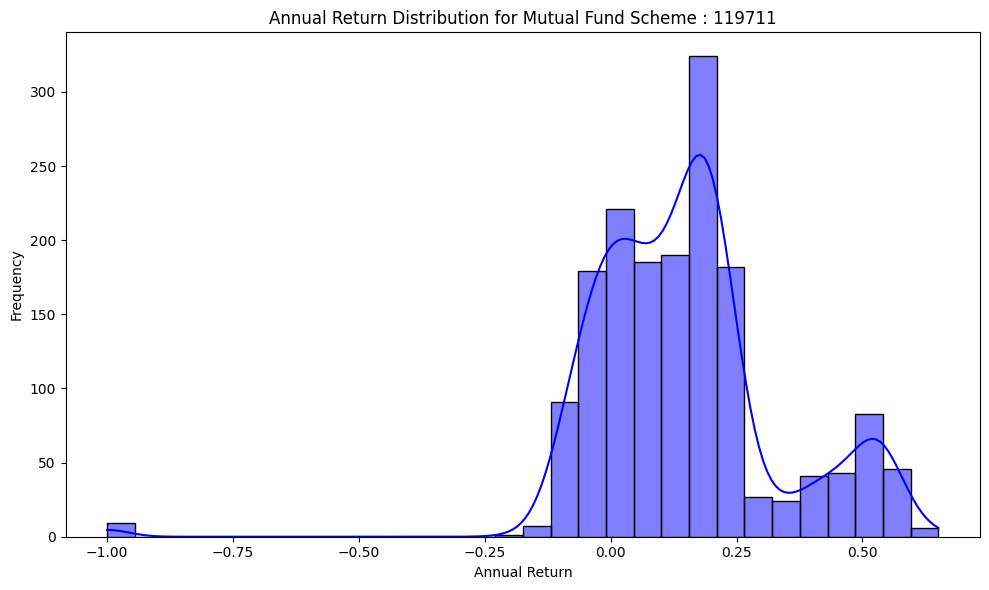

0.1808461947398807


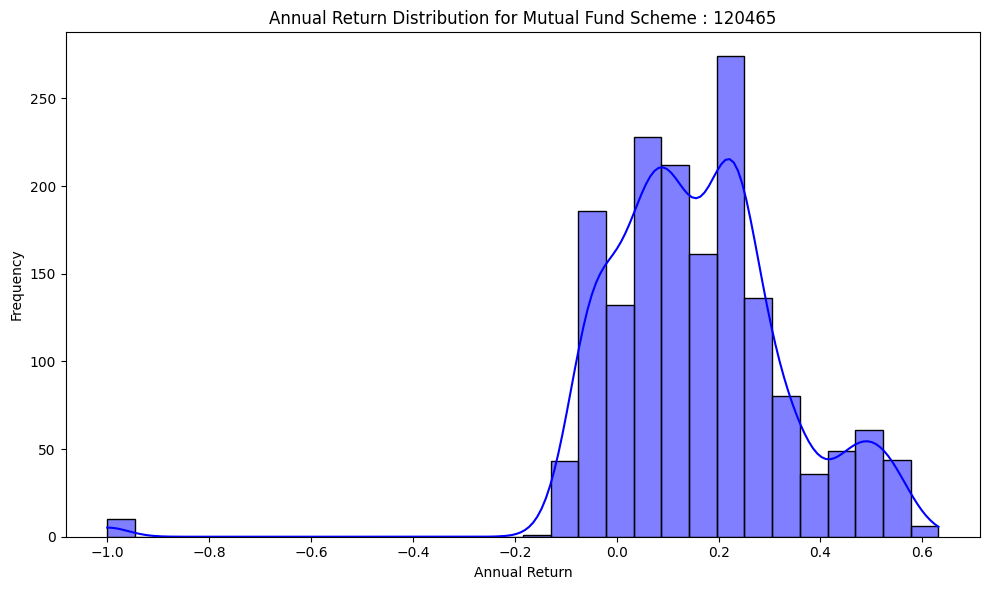

0.22012597791435232


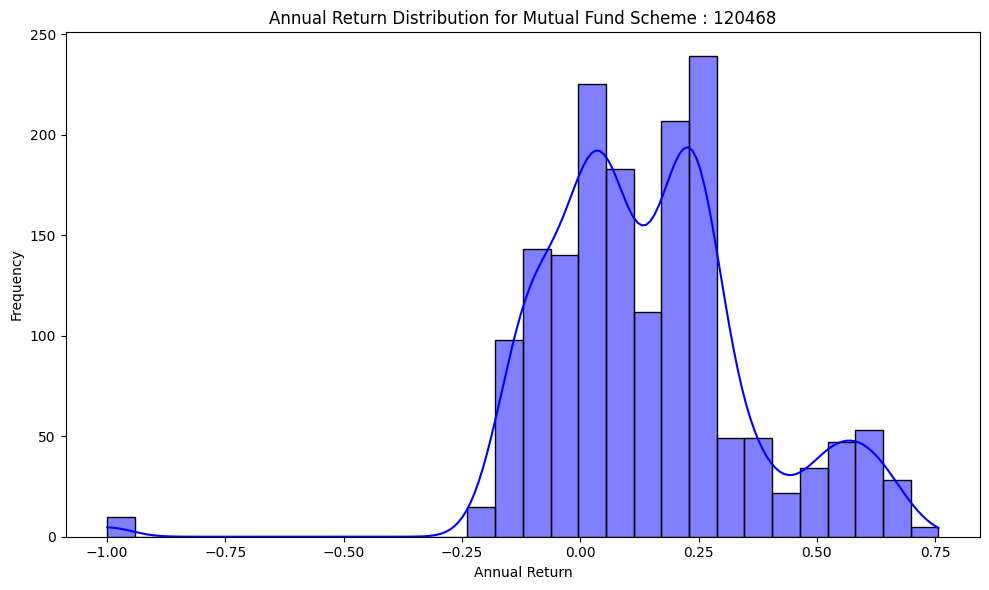

0.29567379281261297


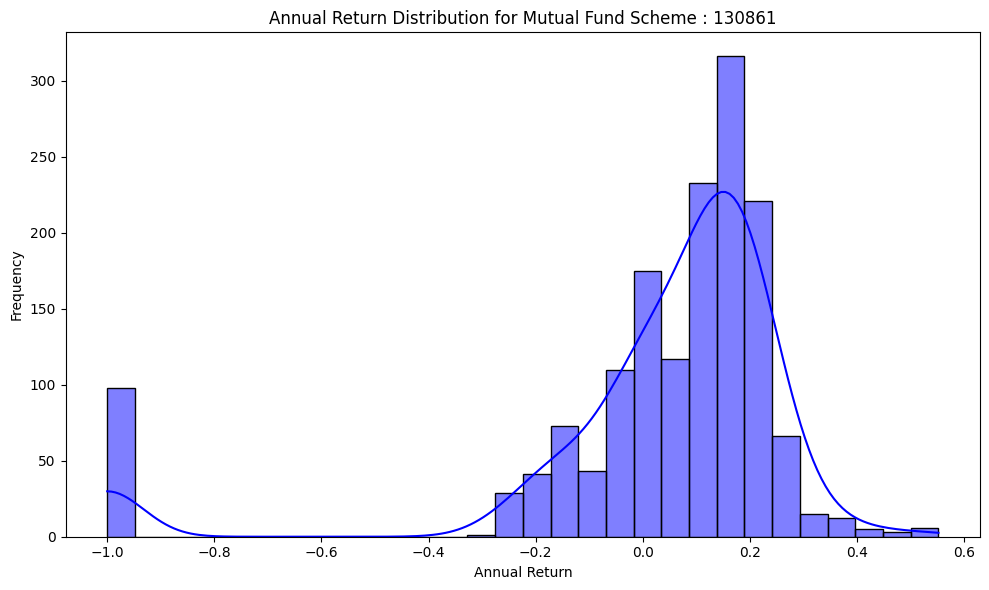

0.2647075973545881


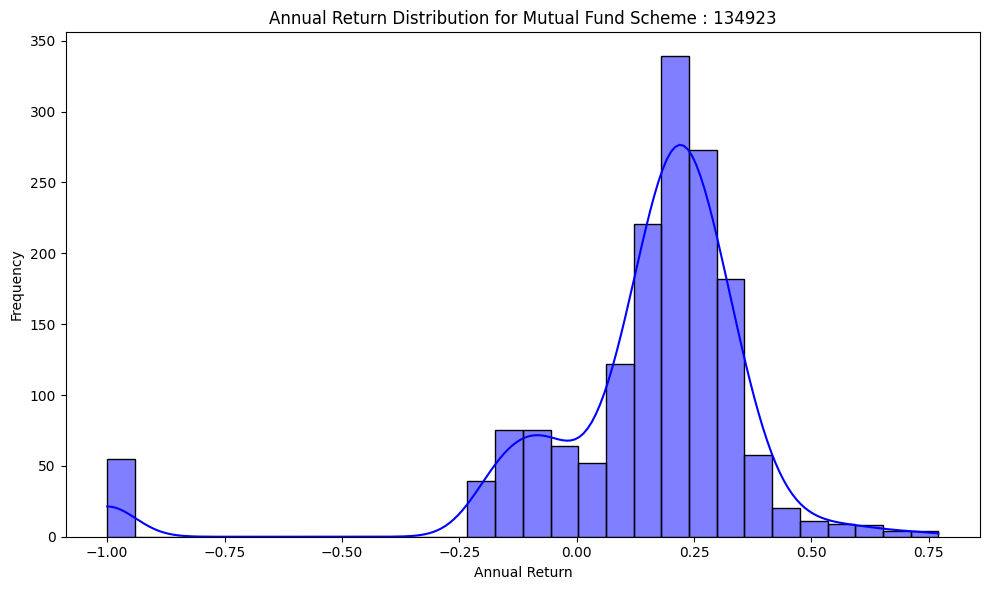

In [34]:
window_size = 252

annual_returns = all_mf_ts_df.pct_change(window_size)
# Step 2: Define a rolling window size (e.g., 252 trading days = 1 year)

# Step 3: Calculate annualized return and volatility using the rolling window
daily_returns = all_mf_ts_df.pct_change()
daily_returns = daily_returns.replace([np.inf, -np.inf], np.nan).dropna()

rolling_annual_volatility_std = annual_returns.replace([np.inf, -np.inf], np.nan).dropna().std() # Annualized volatility

# Step 5: Plot histograms and KDE for normality check
for stock in daily_returns.columns:
    plt.figure(figsize=(10, 6))
    
    # Plot annual returns
    plt.subplot(1, 1, 1)
    sns.histplot(annual_returns[stock], kde=True, bins=30, color='blue')
    plt.title(f'Annual Return Distribution for Mutual Fund Scheme : {stock}')
    plt.xlabel('Annual Return')
    plt.ylabel('Frequency')
    
    print(rolling_annual_volatility_std[stock])
    
    plt.tight_layout()
    plt.savefig(r'../results/figures/historical_distributions/annual_return_distribution_' + stock)
    plt.show()
    

In [35]:
rolling_annual_volatility = annual_returns.replace([np.inf, -np.inf], np.nan).dropna() # Annualized volatility
rolling_annual_volatility

,118267,118269,118273,118278,118494,118510,118527,118533,118537,118539,...,118979,119333,119436,119517,119556,119711,120465,120468,130861,134923
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,0.380669,0.306925,0.411462,0.506783,0.390751,0.309736,0.351369,0.397844,0.181139,0.352723,...,0.447124,0.337023,0.409888,0.129742,0.554923,0.417247,0.384295,0.462298,0.163420,0.169504
2018-01-05,0.377303,0.297756,0.411487,0.499783,0.386772,0.307797,0.345289,0.398249,0.194853,0.358422,...,0.431756,0.330709,0.401781,0.128122,0.551741,0.420142,0.384338,0.471864,0.161642,0.190608
2018-01-08,0.392662,0.310440,0.423161,0.511221,0.399338,0.316043,0.355109,0.407361,0.225893,0.370433,...,0.454349,0.328520,0.408000,0.138760,0.571167,0.428870,0.393079,0.479608,-1.000000,0.186233
2018-01-10,0.387695,0.305252,0.405844,0.494417,0.391477,0.309665,0.349116,0.400284,0.232118,0.366143,...,0.414309,0.316198,0.384809,0.145238,0.556547,0.412118,0.377504,0.461499,0.189175,0.187025
2018-01-11,0.371632,0.289417,0.387900,0.483047,0.377815,0.297570,0.343738,0.390275,0.232606,0.354314,...,0.401738,0.286632,0.363355,0.145027,0.539974,0.404329,0.365854,0.446981,0.187986,0.189884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,0.691834,0.389564,0.496103,0.460107,0.434729,0.429216,0.488073,0.555106,0.513020,0.714236,...,0.595125,0.358193,0.368244,0.183810,0.406900,0.147655,0.361272,0.372836,-1.000000,0.252743
2024-09-24,0.691525,0.383999,0.484905,0.451676,0.429354,0.422284,0.484005,0.547867,0.494002,0.695447,...,0.590604,0.348966,0.362077,0.178870,0.394978,0.136137,0.356530,0.363916,0.175631,0.246822
2024-09-25,0.698178,0.378599,0.475172,0.441698,0.429996,0.409972,0.491114,0.539034,0.474846,0.690194,...,0.588018,0.341553,0.353267,0.181473,0.385144,0.132757,0.349368,0.350235,0.173297,0.254826


In [36]:
rolling_annual_volatility_std

118267    0.317012
118269    0.190027
118273    0.202824
118278    0.238542
118494    0.315730
118510    0.274440
118527    0.283598
118533    0.274272
118537    0.294159
118539    0.315115
118559    0.194965
118588    0.296974
118675    0.266874
118762    0.349402
118868    0.209080
118979    0.391289
119333    0.217113
119436    0.265737
119517    0.136430
119556    0.376531
119711    0.189361
120465    0.180846
120468    0.220126
130861    0.295674
134923    0.264708
dtype: float64

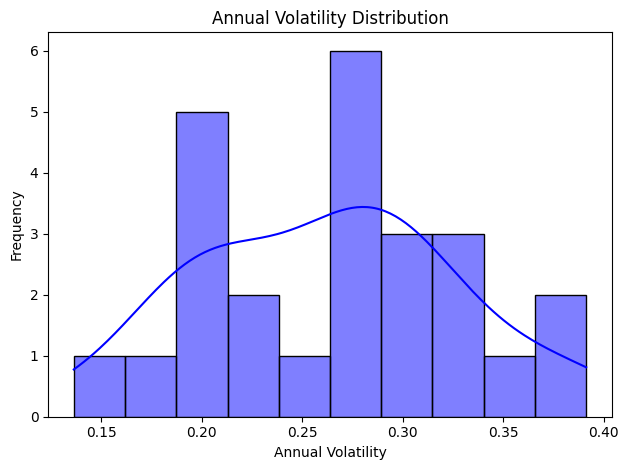

In [38]:
# plt.figure(figsize=(14, 16))
    
# # Plot annual returns
# plt.subplot(3, 1,1)
# sns.histplot(rolling_annual_volatility_std, kde=True, bins=5, color='blue')
# plt.title(f'Annual Volatility Distribution')
# plt.xlabel('Annual Volatility')
# plt.ylabel('Frequency')


# Plot annual returns
plt.subplot(1, 1,1)
sns.histplot(rolling_annual_volatility_std, kde=True, bins=10, color='blue')
plt.title(f'Annual Volatility Distribution')
plt.xlabel('Annual Volatility')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(r'../results/figures/historical_distributions/annual_volatility_distribution')
plt.show()

# # Plot annual returns
# plt.subplot(3, 1,3)
# sns.histplot(rolling_annual_volatility_std, kde=True, bins=15, color='blue')
# plt.title(f'Annual Volatility Distribution')
# plt.xlabel('Annual Volatility')
# plt.ylabel('Frequency')

In [93]:
daily_returns

,118267,118269,118273,118278,118494,118510,118527,118533,118537,118539,...,118979,119333,119436,119517,119556,119711,120465,120468,130861,134923
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-05,0.008922,0.012188,0.010654,0.009336,0.011220,0.009697,0.013664,0.009351,-0.003297,0.008111,...,0.013788,0.015375,0.013542,0.006883,0.009974,0.005294,0.009360,0.007280,0.008253,-0.006069
2017-01-06,-0.009089,-0.003831,-0.001818,-0.001734,-0.002188,-0.002639,-0.000126,-0.000920,-0.013771,-0.002008,...,-0.003835,0.006663,-0.000956,0.002343,-0.002833,-0.002090,-0.002576,0.000000,0.000999,0.006180
2017-01-09,-0.003223,0.000000,0.003277,0.000579,0.002988,-0.002205,0.002491,-0.001412,0.003598,-0.003897,...,0.005473,0.001805,0.003291,0.003057,-0.000201,-0.000650,-0.001033,-0.001549,-1.000000,0.003789
2017-01-11,0.008648,0.013129,0.013709,0.009018,0.010088,0.011896,0.006569,0.010138,0.005334,0.011136,...,0.014499,0.023909,0.015345,0.000509,0.014150,0.008240,0.010786,0.011807,0.001787,0.001897
2017-01-12,0.008574,0.003780,-0.000712,-0.001135,0.000548,0.001029,-0.001082,-0.002095,0.008835,0.001504,...,0.001517,0.000584,0.001488,0.000443,0.001347,-0.000248,0.003049,0.000507,0.003047,0.000855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,0.008809,0.008278,0.010904,0.008793,0.007355,0.007445,0.008326,0.008750,0.000554,0.007918,...,0.007487,0.004505,0.006177,0.003857,0.004186,0.003678,0.007338,0.004827,-1.000000,0.000865
2024-09-25,0.002396,0.000000,-0.004273,-0.003634,0.001653,-0.003701,0.004157,-0.005486,-0.006112,-0.003237,...,-0.000673,-0.001422,-0.003293,-0.002721,-0.001814,-0.006286,-0.000825,-0.006170,0.006584,-0.004569
2024-09-26,-0.001062,0.006603,0.004735,0.004908,0.004192,0.004378,0.006316,-0.002223,0.001200,-0.001067,...,0.001292,0.006991,0.002440,0.010913,-0.000220,0.002990,0.006745,0.005603,0.015787,0.011187
